In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats

from datasets import (load_AlphaFold_RoseTTAFold,
                      load_I3D_exp_20,
                      load_interface_area)
from plotting import COLOR_I3D

In [ ]:
afrf = load_AlphaFold_RoseTTAFold()
df = pd.read_csv('../data/internal/Interface-area-and-energy_Humphreys-Science-2021.tsv', sep='\t')
energy = pd.read_csv('../data/internal/foldx_AC_optimized_repaired_humphreys.txt', sep='\t')
energy['filename'] = energy['Pdb'].str.slice(len('./Optimized_'), -len('_Repair.pdb'))
df = pd.merge(df.iloc[:, :4], energy, how='left', on='filename')
afrf = pd.merge(afrf,
         df,
         left_on=['gene name1', 'gene name2'],
         right_on=['gene1', 'gene2'],
         how='left')
afrf['pair'] = afrf['orf_name_a'] + '_' + afrf['orf_name_b']
afrf = afrf.set_index('pair')
i3d = load_I3D_exp_20(remove_homodimers=True)
ia = load_interface_area()
i3d['interface_area'] = i3d.index.map(ia)
energy_i3d = pd.read_csv('../data/internal/foldx_AC_optimized_repaired_I3D-exp-20.txt', sep='\t')
energy_i3d['filename_short'] = energy_i3d['Pdb'].str.slice(len('./Optimized_'), -len('_Repair.pdb'))
i3d['filename_short'] = i3d['FILENAME'].apply(lambda x: x.split('.')[0])
i3d = pd.merge(i3d,
                energy_i3d,
                on=['filename_short'],
                how='left')
i3d['pair'] = i3d['orf_name_a'] + '_' + i3d['orf_name_b']
i3d = i3d.set_index('pair')

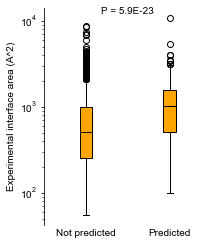

In [3]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3, h=4)
a = i3d.loc[~i3d.index.isin(afrf.index), 'interface_area'].dropna().values
b = i3d.loc[i3d.index.isin(afrf.index), 'interface_area'].dropna().values
bplot = ax.boxplot([a, b],
            labels=['Not predicted', 'Predicted'],
            patch_artist=True,
            medianprops={'color': 'black'})
for patch, color in zip(bplot['boxes'], [COLOR_I3D, COLOR_I3D]):
    patch.set_facecolor(color)
p = stats.mannwhitneyu(a, b)[1]
ax.text(s='P = {:.1E}'.format(p), x=1.5, y=ax.get_ylim()[1], ha='center', va='bottom')
ax.set_yscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('Interface area (A^2)')
#ax.set_ylim(1, 20000)
ax.set_ylabel('Experimental interface area (A^2)')
plt.savefig('../figures/interface-area_experimental_predicted-vs-not.pdf',
            bbox_inches='tight')

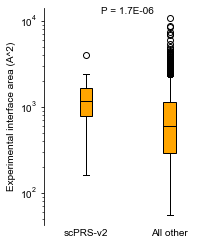

In [4]:
prs = pd.read_csv('../supplementary_tables/scPRS-v2.tsv', sep='\t')
prs['pair'] = prs['orf_name_a'] + '_' + prs['orf_name_b']

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3, h=4)
a = i3d.loc[i3d.index.isin(prs['pair'].values), 'interface_area'].dropna().values
b = i3d.loc[~i3d.index.isin(prs['pair'].values), 'interface_area'].dropna().values
bplot = ax.boxplot([a, b],
            labels=['scPRS-v2', 'All other'],
            patch_artist=True,
            medianprops={'color': 'black'})
for patch, color in zip(bplot['boxes'], [COLOR_I3D, COLOR_I3D]):
    patch.set_facecolor(color)
p = stats.mannwhitneyu(a, b)[1]
ax.text(s='P = {:.1E}'.format(p), x=1.5, y=ax.get_ylim()[1], ha='center', va='bottom')
ax.set_yscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('Interface area (A^2)')
#ax.set_ylim(1, 20000)
ax.set_ylabel('Experimental interface area (A^2)')
plt.savefig('../figures/interface-area_experimental_PRS-vs-not.pdf',
            bbox_inches='tight')
